# Prerequisites
Before you can execute this notebook you'll need the graph logs which you can generate by running the `nervenet_graph_generation.py` in the `NerveNet` subfolder

In [1]:
import pandas as pd
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_sparse
import networkx as nx

In [2]:
from NerveNet.graph_util.mujoco_parser import parse_mujoco_graph
from NerveNet.graph_util.mujoco_parser_settings import  RootRelationOption

In [34]:
#some settings
edge_colors = {
    10:"blue", # root-body
    3:"green", # body-body
    6:"blue", # joint-body
}

def visualize_task_graph(task_name:str,
                         figsize=(10, 10),
                         use_sibling_relations: bool = True,
                         root_relation_option: RootRelationOption = RootRelationOption.BODY):
    fig = plt.figure(figsize=figsize)
    
    task_log = parse_mujoco_graph(task_name=task_name, 
        use_sibling_relations=use_sibling_relations,
        root_relation_option=root_relation_option)
    
    node_colors = {
        "red": task_log["node_type_dict"]["root"],
        "blue": task_log["node_type_dict"]["joint"],
        "black": task_log["node_type_dict"]["body"],
    }

    node_names = {node["id"]: node["raw_name"] for node in task_log["tree"] if "raw_name" in node.keys()}
    node_names[0] = "root"
    
    # Generate graph structure
    G = nx.Graph()
    for i in range(task_log["num_nodes"]):
        G.add_node(i)
        for j in range(i, task_log["num_nodes"]):
            if task_log["relation_matrix"][i][j] != 0:
                G.add_edge(i, j)
    
    pos = nx.spring_layout(G)#, pos={0: np.array([ 0, 0])})

    options = {"node_size": 600, "alpha": 0.8}
    for color, nodes in node_colors.items():
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, **options)
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, **options)


    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    for p in pos:  # raise text positions
        pos[p][1] += 0.055
    nx.draw_networkx_labels(G, pos, node_names, font_size=20)
    
    plt.savefig('robot.png')
    plt.show()
    return task_log

In [4]:
#ant_log = visualize_task_graph("AntS-v1")

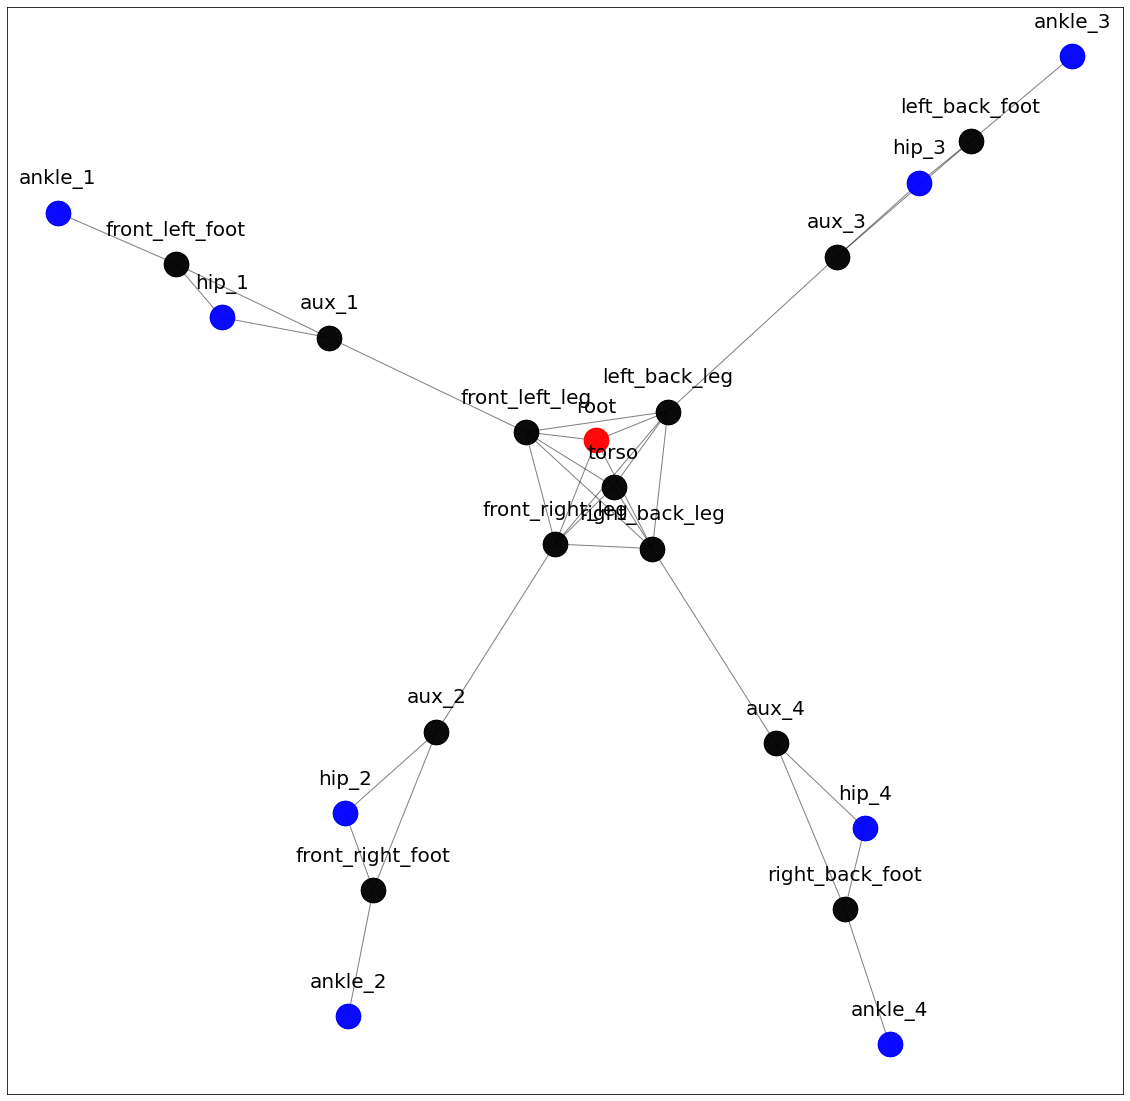

In [52]:
ant_bullet_log = visualize_task_graph("AntBulletEnv-v0",
                                        figsize=(20,20),
                                        use_sibling_relations = True,
                                        root_relation_option = RootRelationOption.NONE
                                        )

In [6]:
HalfCheetah_log = visualize_task_graph("HalfCheetah-v1",
                                        figsize=(15,15),
                                        use_sibling_relations = False,
                                        root_relation_option = RootRelationOption.BODY)

AssertionError: Every node in a group must have the same number of observations

<Figure size 1080x1080 with 0 Axes>

In [ ]:
Hopper_log = visualize_task_graph("HopperBulletEnv-v0", figsize=(10,10),
                                        use_sibling_relations = False,
                                        root_relation_option = RootRelationOption.BODY)

In [ ]:
Humanoid_log = visualize_task_graph("Humanoid-v1",
                                    use_sibling_relations = True,
                                    root_relation_option = RootRelationOption.NONE)

In [ ]:
WalkersKangaroo_log = visualize_task_graph("Walker2DBulletEnv-v0")

In [ ]:
#WalkersOstrich_log = visualize_task_graph("WalkersOstrich-v1")

In [ ]:
ant_bullet_log.keys()

In [ ]:
relation_matrix = ant_bullet_log["relation_matrix"]
obs_input_mapping = ant_bullet_log["obs_input_mapping"]
input_type_dict = ant_bullet_log["input_type_dict"]
static_input_mapping = ant_bullet_log["static_input_mapping"]
num_nodes = ant_bullet_log["num_nodes"]
num_node_features = ant_bullet_log["num_node_features"]

In [ ]:
batch_size = 2
observation_sample_size = max(list(obs_input_mapping.values()))[0]+ 1
observations = torch.arange(batch_size * observation_sample_size).reshape((batch_size, observation_sample_size)).to(torch.float32,)

In [ ]:
observations

In [ ]:
from NerveNet.graph_util.observation_mapper import observations_to_node_attributes
observations_to_node_attributes(observations,
                                obs_input_mapping,
                                static_input_mapping,
                                num_nodes,
                                num_node_features).shape

In [ ]:
batch_size, observation_sample_size = observations.shape
# check that there is a mapping for every element of the observation vector
assert max(list(obs_input_mapping.values()))[
    0] + 1 == observation_sample_size

static_input_mapping = {int(k): np.concatenate(list(v.values()))
                        for k, v in static_input_mapping.items()}
static_input_mapping[0] = np.array([])

In [ ]:
static_input_mapping

In [ ]:
obs_input_mapping

In [ ]:
input_mask_dict = {}
for group_name, group_nodes in input_type_dict.items():
    # assumes every node of a group has the same input sizes
    in_size = len(obs_input_mapping[group_nodes[0]])
    static_in_size = len(static_input_mapping[group_nodes[0]])
    input_mask_dict[group_name] = (group_nodes, in_size + static_in_size)
input_mask_dict

In [ ]:
# ant_bullet_log["relation_matrix"]

In [ ]:
attributes = -torch.ones(batch_size,
                                 num_nodes,
                                 num_node_features,
                                 dtype=torch.float32,
                                 device=observations.device)

for i in range(num_nodes):
    in_size = len(obs_input_mapping[i])
    static_in_size = len(static_input_mapping[i])

    in_mask = list(range(in_size))
    static_in_mask = list(range(in_size, in_size+static_in_size))

    attributes[:, i, in_mask] = observations[:, obs_input_mapping[i]]
    attributes[:, i, static_in_mask] = torch.from_numpy(
        static_input_mapping[i]).expand(batch_size, -1).float().to(observations.device)

In [ ]:
attributes[:, input_type_dict["root_mujocoroot"]].shape

In [ ]:
attributes[:, input_mask_dict["foot"][0], 0:input_mask_dict["foot"][1]]

In [ ]:
0

In [ ]:
1 

In [ ]:
ant_bullet_log["input_type_dict"]

In [ ]:
[node for node in ant_bullet_log["tree"] if node["id"] in ant_bullet_log["output_list"]]

In [ ]:
dict(enumerate([node for node in ant_bullet_log["tree"] if node["type"] == "joint"]))